## Interpretability: LIME and SHAP in prose and code

Being able to explain how a model works serves many purposes, including building trust in the model's output, satisfying regulatory requirements, model debugging, and verifying model safety, amongst other things.


- An overview of model interpretability
- Interpreting white box models, such as Linear/Logistic Regression (using model coefficients) and Tree models (using feature importance scores)
- Interpreting black box models with LIME and SHAP (TreeExplainer) and how to implement this in python



 


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import csv
import sqlite3
import shap
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from matplotlib import pyplot
from sklearn.utils import shuffle
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.metrics import classification_report


import shap
from lime.lime_tabular import LimeTabularExplainer
import xgboost
import seaborn as sns; 
import umap 

 
import matplotlib.pyplot as plt
import matplotlib 

In [2]:
idcol = 'ClientID'
labelcol = 'StageName'
cols = (('RecordType.Name', True),
        ('RICE_Supported__c', True),
        ('Lead_Faculty__c', True),
        ('Lead_School__c', True),
        ('Parent_Opportunity__c', False),
        ('Industry', True),
        ('Industry_Sub_Type__c', True),
        ('Business_Type__c', True),
        ('Is_External__c', False),
        ('ParentId', False),
        ('tasks_events', False),
        ('CreatedYear', False),
        ('CreatedMonth', False)
       , ('days', False),
        ('RN', False),
        ('f_won_before', False)
       # ,('oppo_busi', True),
       #('fac_oppo', True),
       # ('oppo_Industry', True)
)

def drop_non_features(df, cols):
    return df[[c for c, _ in cols]]

def drop_missing(df):
    '''Remove rows with missing values'''
    return df.replace(r'^\s$', np.nan, regex=True).dropna()


def categorize(df, cols):
    catcols = (c for c, iscat in cols if iscat)
    for col in catcols:
        df[col] = pd.Categorical(df[col])
    return df

def booleanize_senior_citizen(df):
    '''Make SeniorCitizen 'Yes'/'No' like other columns in this dataset.'''
    return df.replace({'SeniorCitizen': {1: 'Yes', 0: 'No'}})

def splitdf(df, label):
    return df.drop(label, axis=1), df[label]

def load_dataset():
    '''Return IBM customers and labels.'''
    df = pd.read_csv("C:/Users/BingLesleyYuan/Desktop/UniProj/Project-90106-G28/cleaned-17-Oct.csv")
    df = drop_missing(df).reset_index()
    df=df.append(df[df.StageName==1])
    df= shuffle(df)
    df.index.name = 'id'
    features, labels =  splitdf(df, labelcol)
    features = drop_non_features(features, cols)
    features = categorize(features, cols)

    labels = (labels == 1)
    return features, labels
  
def setup_plot():
    plt.rcParams["axes.grid.axis"] ="y"
    plt.rcParams["axes.grid"] = True
    plt.rcParams["legend.fontsize"] = 14
    plt.rc('grid', linestyle="dashed", color='lightgrey', linewidth=1)
    plt.rcParams["xtick.labelsize"] = 15
    plt.rcParams["ytick.labelsize"]  = 15 

## The Dataset


- The dataset contains both continuous and categorical features.

- Depending on the type of model, we can make different decisions on how categorical fields are represented. For example, tree-based models can be trained directly with categorical features (label encoded), while other models (e.g. Logistic regression, Neural Networks) work better with one hot encoded categorical variables. 





In [3]:
data, labels = load_dataset()  

# Get categorical column indexes
cat_columns_ix_ = {c: i for i, c in enumerate(data.columns)
                                if pd.api.types.is_categorical_dtype(data[c])}
# categorical column names
cat_columns  = [c for c in (data.columns) if pd.api.types.is_categorical_dtype(data[c])]
# num_cat_columns  = [c for c in (data.columns) if pd.api.types.is_categorical_dtype(data[c])]

# Make copies of data with various representations for categorical features. 
data_numeric = data.copy() # categorical fields are label encoded but numerical
data_categorical = data.copy() # categorical fields are label encoded, numeric but categorical type
data_copy = data.copy() # categorical fields are label encoded, numeric but categorical type
data_ohe =  pd.get_dummies(data,columns=cat_columns, sparse=False) # categorical fields are one hot encoded

# Convert categorical columns to numeric encoded labels
for col in cat_columns:
    data_copy[col+"_cat"]=(LabelEncoder().fit_transform(data_copy[col]))
    data_numeric[col] = (LabelEncoder().fit_transform(data_numeric[col]))
    
    data_categorical[col] = data_numeric[col].astype("category")  


# Set data used for explorations
# Hint .. Change this to other version of the data and observe changes in results.
current_data = data_categorical  
print("Available features: \n", list(data_categorical.columns)) 
print("Label Balance - [yes, no] : ", list(labels.value_counts()))                                                      

Available features: 
 ['RecordType.Name', 'RICE_Supported__c', 'Lead_Faculty__c', 'Lead_School__c', 'Parent_Opportunity__c', 'Industry', 'Industry_Sub_Type__c', 'Business_Type__c', 'Is_External__c', 'ParentId', 'tasks_events', 'CreatedYear', 'CreatedMonth', 'days', 'RN', 'f_won_before']
Label Balance - [yes, no] :  [4042, 3387]


## Model Training

We can train a set of models on the churn dataset and compare their performance. To simplify this process, we will use the sklearn library and utilize the `model.fit()` api to train the model while recording train and test accuracy. The following models are trained:

- Naive Bayes
- Logistic Regression
- Decision Tree
- Random Forest
- Gradient Boosted Tree 
- Multilayer Perceptron

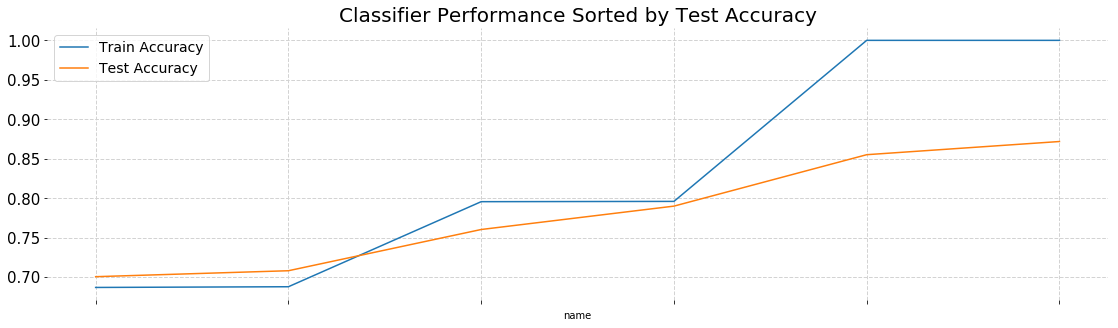

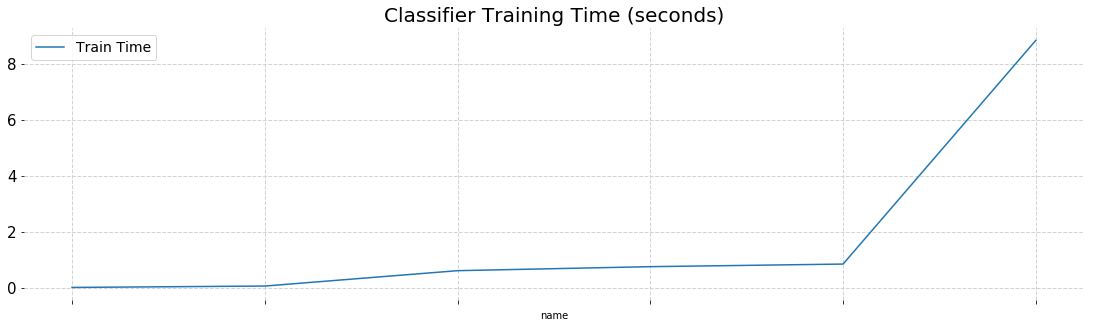

In [6]:
#@title
import time
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegressionCV

trained_models = [] #  keep track of all details for models we train
def train_model(model, data, labels): 
  X = data
  y = labels.values
  X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

  pipe = Pipeline([('scaler', StandardScaler()),('clf', model["clf"])])
  start_time = time.time()
  pipe.fit(X_train, y_train)
  train_time = time.time() - start_time

  train_accuracy =  pipe.score(X_train, y_train)
  test_accuracy = pipe.score(X_test, y_test) 
  model_details = {"name": model["name"], "train_accuracy":train_accuracy, "test_accuracy":test_accuracy, "train_time": train_time, "model": pipe}
  return model_details

models = [
          {"name": "Naive Bayes", "clf": GaussianNB()},
          {"name": "logistic regression", "clf": LogisticRegressionCV()}, 
          {"name": "Decision Tree", "clf": DecisionTreeClassifier()},
          {"name": "Random Forest", "clf": RandomForestClassifier(n_estimators=100)},
          {"name": "Gradient Boosting", "clf": GradientBoostingClassifier(n_estimators=100)}, 
          {"name": "MLP Classifier", "clf": MLPClassifier(solver='adam', alpha=1e-1, hidden_layer_sizes=(10,10,5,2), max_iter=500, random_state=42)}]

for model in models:
  model_details = train_model(model, current_data, labels) 
  trained_models.append(model_details)


# visualize accuracy and run time
setup_plot()
model_df = pd.DataFrame(trained_models)
model_df.sort_values("test_accuracy", inplace=True) 
ax = model_df[["train_accuracy","test_accuracy", "name"]].plot(kind="line", x="name", figsize=(19,5), title="Classifier Performance Sorted by Test Accuracy")
ax.legend(["Train Accuracy", "Test Accuracy"])
for p in ax.patches:
    ax.annotate( str( round(p.get_height(),3) ), (p.get_x() * 1.005, p.get_height() * 1.005))

ax.title.set_size(20)
plt.box(False)

model_df.sort_values("train_time", inplace=True)
ax= model_df[["train_time","name"]].plot(kind="line", x="name", figsize=(19,5), grid=True, title="Classifier Training Time (seconds)")
ax.title.set_size(20)
ax.legend(["Train Time"])
plt.box(False)  

## Explaining Models

At this point, we have a few models trained, and we can use them to obtain predictions. Given the data for each cable customer, we can predict the probability that they will churn. However, what is not very clear is how each of these features contribute to the predicted churn probability. We can think of these explanations in **global** terms (i.e., how does each feature impact outcomes on the average for the entire datasheet?) or in **local** terms (i.e., how does each feature impact predictions for a given customer?).
Some models have inbuilt properties that provide these sorts of explanations. These are typically referred to as **white box** models and examples include linear regression (model coefficients), logistic regression (model coefficients) and decision trees (feature importance). Due to their complexity, other models - such as Random Forests, Gradient Boosted Trees, SVMs, Neural Networks etc. - do not have straightforward methods for explaining their predictions. For these models, (also known as **black box** models), approaches such as LIME and SHAP can be applied.





### Global Explanation - Logistic Regression Coefficients
For models such as linear and logistic regression, we can look at the model coefficients to infer feature importance This gives us some idea of how an increase/change in each feature might result in a change in the log odds that the customer will churn. We can also get a general understanding of how important a feature is for the entire dataset.

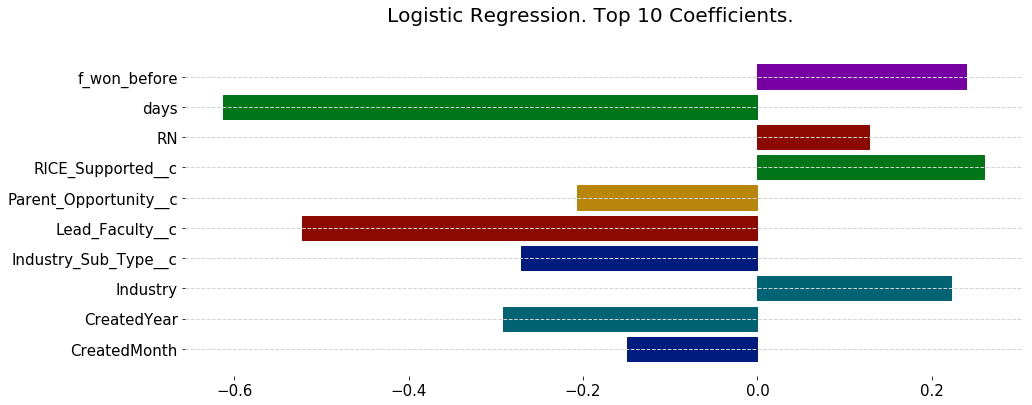

In [7]:
plt.figure(figsize=(15,6))
X_train, X_test, y_train, y_test = train_test_split(current_data, labels.values, random_state=42)
logistic_reg_coeff = trained_models[1]["model"]["clf"].coef_
color_list =  sns.color_palette("dark", len(current_data.columns)) 
top_x = 10
logistic_reg_coeff = trained_models[1]["model"]["clf"].coef_[0]
idx = np.argsort(np.abs(logistic_reg_coeff))[::-1] 
lreg_ax = plt.barh(current_data.columns[idx[:top_x]][::-1], logistic_reg_coeff[idx[:top_x]][::-1])
for i,bar in enumerate(lreg_ax):
  bar.set_color(color_list[idx[:top_x][::-1][i]])
  plt.box(False) 
lr_title = plt.suptitle("Logistic Regression. Top " + str(top_x) + " Coefficients.", fontsize=20, fontweight="normal")


# Explanations via Feature Importance Scores [Tree Based Models]

Tree-based models have properties that let us infer the importance of a feature. For each decision tree, we can compute the mean decrease in impurity for each feature - i.e., how impactful the feature is in reducing the uncertainty (classifiers) or variance (regressors) of the decision tree prediction. This value is also known as the gini importance score. For each tree based model in our list of trained models, we can leverage the sklearn `feature_importance` implementation and visualize the average importance of each variable.


Text(0.5,0.98,'Feature Importance for Tree Models. Top 10 Features.')

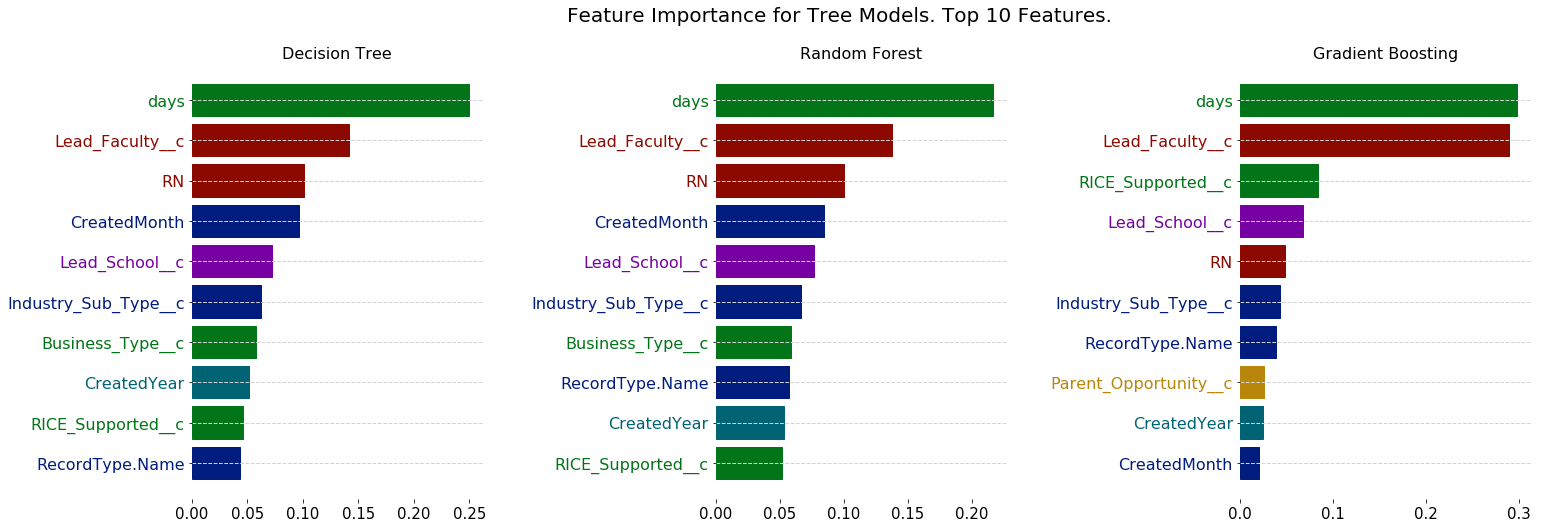

In [8]:
#@title
# Create array of tree based models and plot feature importance scores
tree_models = []
setup_plot()
color_list =  sns.color_palette("dark", len(current_data.columns)) 
top_x = 10 # number of x most important features to show
for model in trained_models:
  if hasattr(model["model"]["clf"], 'feature_importances_'): 
    tree_models.append({"name":model["name"], "fi": model["model"]["clf"].feature_importances_}) 
  

fig, axs = plt.subplots(1,3, figsize=(24, 8), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = 0.5, wspace=0.8)
axs = axs.ravel()
for i in range(len(tree_models)):
  feature_importance = tree_models[i]["fi"]
  indices = np.argsort(feature_importance)
  indices = indices[-top_x:]

  bars = axs[i].barh(range(len(indices)), feature_importance[indices], color='b', align='center') 
  axs[i].set_title( tree_models[i]["name"], fontweight="normal", fontsize=16)

  plt.sca(axs[i])
  plt.yticks(range(len(indices)), [current_data.columns[j] for j in indices], fontweight="normal", fontsize=16) 

  # print(len(plt.gca().get_yticklabels()), len(indices))
  for i, ticklabel in enumerate(plt.gca().get_yticklabels()):
    ticklabel.set_color(color_list[indices[i]])  

  for i,bar in enumerate(bars):
    bar.set_color(color_list[indices[i]])
  plt.box(False)
  
plt.suptitle("Feature Importance for Tree Models. Top " + str(top_x) + " Features.", fontsize=20, fontweight="normal")
 



There are several limitations here. 
- Feature importance measures are global estimates across the entire training dataset. For a subset of customers, within the same model, the order and magnitude of feature importance may change (see the section below on local instance explanations). Thus, while we know `facutlty` are important on the average we cannot confidently answer the question:  how does changes affect the conversion rate?

- There are known biases related to how the feature importance score is computed. See ([Bias in random forest variable importance measures: Illustrations, sources and a solution](https://link.springer.com/article/10.1186%2F1471-2105-8-25))


These limitations make it desirable to explore local explanations.


## Explanations with LIME

Local Interpretable Model-agnostic Explanation ([LIME](https://arxiv.org/abs/1602.04938)) provides a fast and relatively simple method for `locally` explaining black box models. The LIME algorithm can be simplified into a few steps

- For a given data point, randomly perturb its features repeatedly. For tabular data, this entails adding a small amount of noise to each feature.  
- Get predictions for each perturbed data instance. This helps us build up a local picture of the decision surface at that point.
- Use predictions to compute an approximate linear "explanation model" using predictions. Coefficients of the linear model are used as explanations.


## LIME Tabular Explainer: Explain a test data instance for all models

In the following section, we will generate and visualize lime explanations for a given data point in our test set. We will do this for all our trained models.

In [21]:
from lime.lime_tabular import LimeTabularExplainer
X_train, X_test, y_train, y_test = train_test_split(current_data, labels, random_state=42) 

def get_lime_explainer(model, data, labels):  

  cat_feat_ix = [i for i,c in enumerate(data.columns) if pd.api.types.is_categorical_dtype(data[c])]
  feat_names = list(data.columns)
  class_names = list(labels.unique())
  scaler = model["model"]["scaler"]
  data = scaler.transform(data) # scale data to reflect train time scaling
  lime_explainer = LimeTabularExplainer(data,
                                      feature_names=feat_names,
                                      class_names=class_names,
                                      categorical_features=cat_feat_ix ,
                                      mode="classification"
                                      )
  return lime_explainer

def lime_explain(explainer, data, predict_method, num_features): 
  explanation = explainer.explain_instance(data, predict_method, num_features=num_features) 
  return explanation

lime_data_explainations = []
lime_metrics = []
lime_explanation_time = []
feat_names = list(current_data.columns)
test_data_index = 100
for current_model in trained_models:  
  scaler = current_model["model"]["scaler"]
  scaled_test_data = scaler.transform(X_test)
  predict_method = current_model["model"]["clf"].predict_proba 

  start_time = time.time()
  # explain first sample from test data
  lime_explainer = get_lime_explainer(current_model, X_train, y_train)
  explanation = lime_explain(lime_explainer, scaled_test_data[test_data_index], predict_method, top_x) 
  elapsed_time = time.time() - start_time 

  ex_holder = {}
  for feat_index,ex in explanation.as_map()[1] :
    ex_holder[feat_names[feat_index]] = ex
  
  lime_data_explainations.append(ex_holder) 
  actual_pred = predict_method(scaled_test_data[test_data_index].reshape(1,-1))
  perc_pred_diff =  abs(actual_pred[0][1] - explanation.local_pred[0])   
  lime_explanation_time.append({"time": elapsed_time, "model": current_model["name"] })
  lime_metrics.append({"lime class1": explanation.local_pred[0], "actual class1": actual_pred[0][1], "class_diff": round(perc_pred_diff,3), "model": current_model["name"] })
  # break 

print(X_test.iloc[test_data_index])
print(y_test.iloc[test_data_index])

RecordType.Name             9
RICE_Supported__c           1
Lead_Faculty__c            15
Lead_School__c             46
Parent_Opportunity__c       0
Industry                    8
Industry_Sub_Type__c        5
Business_Type__c            9
Is_External__c              1
ParentId                    0
tasks_events                0
CreatedYear              2016
CreatedMonth                6
days                      322
RN                          1
f_won_before                0
Name: 2523, dtype: object
False


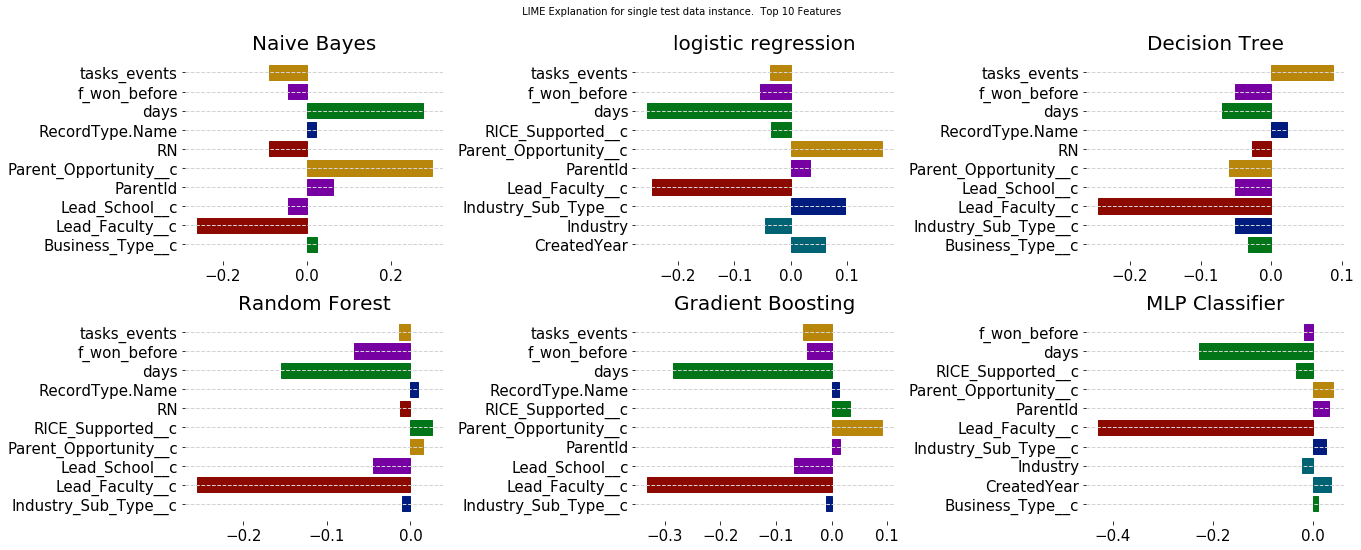

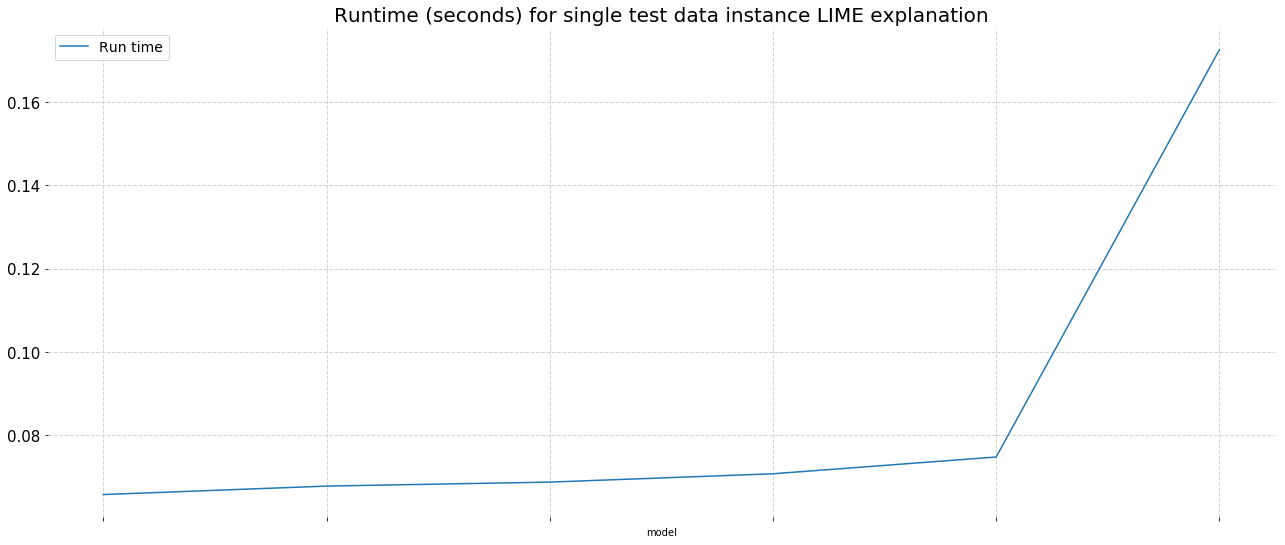

In [22]:
def plot_lime_exp(fig, fig_index, exp_data, title):
  features =  list(exp_data.keys())[::-1]
  explanations = list(exp_data.values())[::-1]
  ax = fig.add_subplot(fig_index) 
  lime_bar = ax.barh( features, explanations ) 
  ax.set_title(title, fontsize = 20)
  for i,bar in enumerate(lime_bar):
    bar.set_color(color_list[list(current_data.columns).index(features[i])])
    plt.box(False) 
fig = plt.figure(figsize=(19,8))

# Plot lime explanations for trained models
for i, dex in enumerate(lime_data_explainations):
  fig_index = "23" + str(i+1)
  plot_lime_exp(fig, fig_index, lime_data_explainations[i], trained_models[i]["name"])

plt.suptitle( " LIME Explanation for single test data instance.  Top " + str(top_x) + " Features", fontsize=10, fontweight="normal")
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

# Plot run time for explanations
lx_df = pd.DataFrame(lime_explanation_time)
lx_df.sort_values("time", inplace=True)
setup_plot()
lx_ax = lx_df.plot(kind="line", x="model", title="Runtime (seconds) for single test data instance LIME explanation", figsize=(22,9))
lx_ax.title.set_size(20)
lx_ax.legend(["Run time"])
plt.box(False)

## Debugging  LIME: Should I trust the Explanation?


Underneath, the LIME algorithm uses an approximate linear model to derive local explanations. Like any other ML model, this explanation model can have *issues* too. So, what can we do to build   confidence in the quality of an explanation. As a first step, we can check if the local model is indeed a good approximator for the original model.    

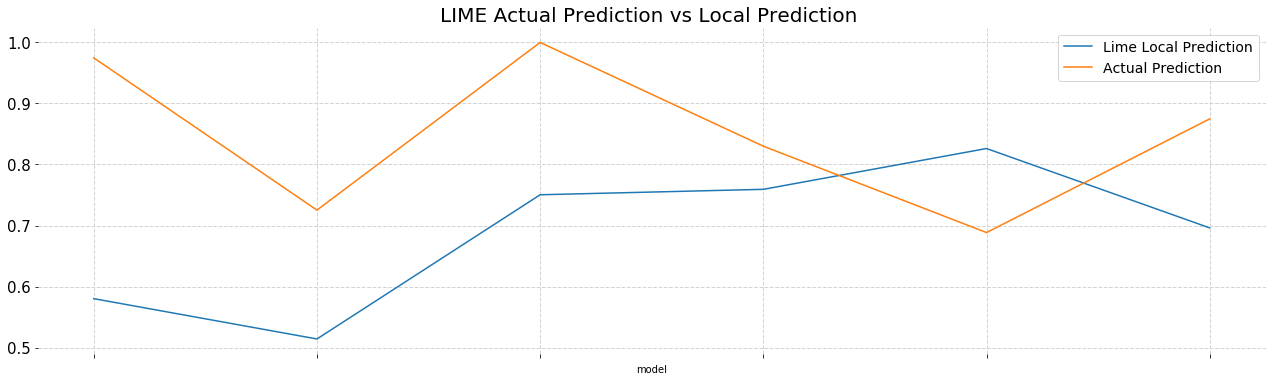

In [10]:
# Plot run time for explanations
lime_metrics_df = pd.DataFrame(lime_metrics)  
lime_metrics_df_ax = lime_metrics_df[["lime class1", "actual class1", "model"]].plot(kind="line", x="model", title="LIME Actual Prediction vs Local Prediction ", figsize=(22,6))
lime_metrics_df_ax.title.set_size(20)
lime_metrics_df_ax.legend(["Lime Local Prediction", "Actual Prediction"])
plt.box(False)

The plot above shows the predictions made by the LIME local model and the original model for the explained data instance. Both numbers should be close.  When they are not, this may raise questions as to if we can trust the explanation. There are few things that can be done:
-  Modify the parameters of LIME to yield a better explanation. E.g. increase the number of perturbations (LIME ) or kernel width (see related discussion  [here](https://github.com/marcotcr/lime/issues/209)), 
- Improve our original model (In this case, we know that the Decision Tree shows signs of overfitting). 

The next explanation method we will consider (SHAP) aims to address such inconsistencies. Let's go!

## Explanations with SHAP

- local accuracy (an approximate model used to explain the original model should match the output of the original model for a given input)
- consistency (if the original model changes such that a feature has a larger impact in every possible ordering, then its attribution should not decrease)



In practice, a few simplifications are required to compute Shapley values. Perhaps the most important is related to how we simulate the adding or removal of features while computing model prediction. This is challenging because there is no straightforward way to "remove" a feature for most predictive models at test time. We can either replace the feature with its mean value, median value. In the SHAP library implementation, a “missing” feature is simulated by replacing the feature with the values it takes in the background dataset. 


## Kernel Explainer



In [34]:
current_model = trained_models[3] # Explain the Random Forest Model
clf = current_model["model"]["clf"]
scaler = current_model["model"]["scaler"]
scaled_train_data = scaler.transform(X_train)
sub_sampled_train_data = shap.sample(scaled_train_data, 200, random_state=0) # use 600 samples of train data as background data

scaled_test_data = scaler.transform(X_test) 
subsampled_test_data =scaled_test_data[test_data_index].reshape(1,-1)

start_time = time.time()
explainer = shap.KernelExplainer(clf.predict_proba, sub_sampled_train_data)
shap_values = explainer.shap_values(subsampled_test_data,  l1_reg="aic")
elapsed_time = time.time() - start_time
# explain first sample from test data
print("Kernel Explainer SHAP run time", round(elapsed_time,3) , " seconds. ", current_model["name"])
print("SHAP expected value", explainer.expected_value)
print("Model mean value", clf.predict_proba(scaled_train_data).mean(axis=0))
print("Model prediction for test data", clf.predict_proba(subsampled_test_data))
shap.initjs()
pred_ind = 0
shap.force_plot(explainer.expected_value[1], shap_values[1][0], subsampled_test_data[0], feature_names=X_train.columns)



Using 200 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


HBox(children=(FloatProgress(value=0.0, max=1.0), HTML(value='')))


Kernel Explainer SHAP run time 7.662  seconds.  Random Forest
SHAP expected value [0.44305 0.55695]
Model mean value [0.44519344 0.55480656]
Model prediction for test data [[0.15 0.85]]


## Tree Explainer



In [47]:
from sklearn.ensemble import RandomForestRegressor
plt.figure(figsize=(15,6))
X_train, X_test, y_train, y_test = train_test_split(current_data, labels.values, random_state=42)
model_rf = RandomForestRegressor(max_depth=6, random_state=0, n_estimators=10)
model_rf.fit(X_train, y_train)

import shap
shap_values = shap.TreeExplainer(model_rf).shap_values(X_train)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


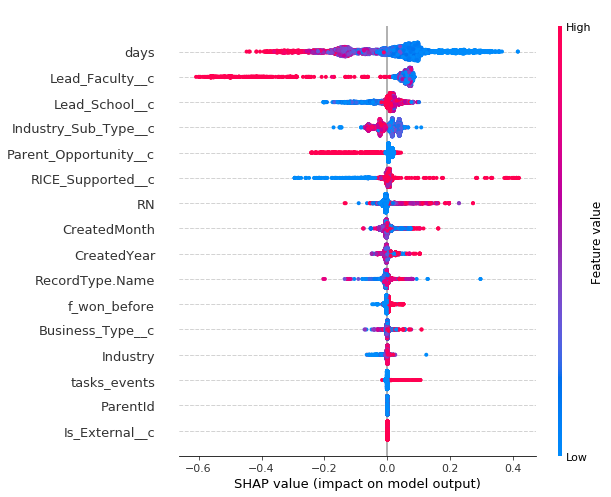

In [48]:
import matplotlib.pyplot as plt
f = plt.figure()
shap.summary_plot(shap_values, X_train)

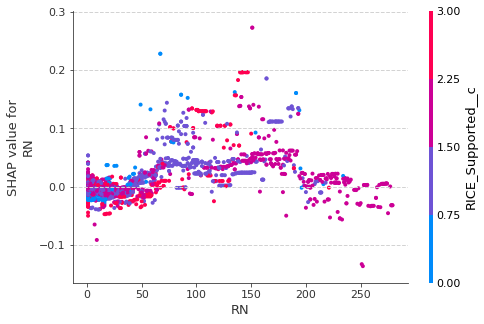

In [53]:
shap.dependence_plot("RN", shap_values, X_train)

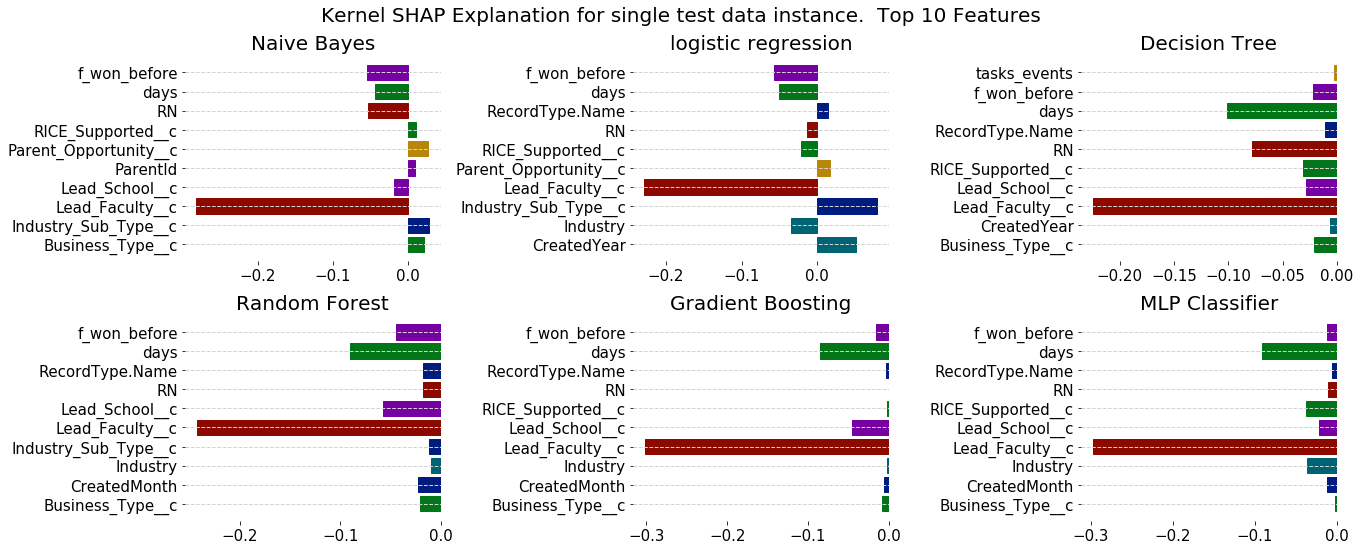

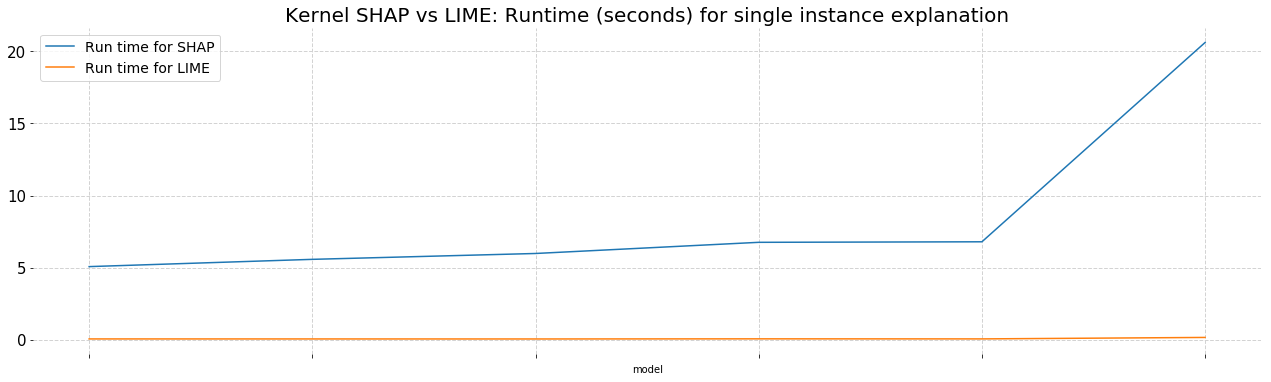

In [31]:
def plot_shap_exp(fig, fig_index, exp_data, title):
  features =  list(exp_data.keys())[::-1]
  explanations = list(exp_data.values())[::-1]
  ax = fig.add_subplot(fig_index) 
  lime_bar = ax.barh( features, explanations ) 
  ax.set_title(title, fontsize = 20)
  for i,bar in enumerate(lime_bar):
    bar.set_color(color_list[list(current_data.columns).index(features[i])])
    plt.box(False) 


# Plot SHAP explanations for a given test set item
fig = plt.figure(figsize=(19,8))
for i, dex in enumerate(shap_data_explainations):
  fig_index = "23" + str(i+1)
  plot_lime_exp(fig, fig_index, shap_data_explainations[i], trained_models[i]["name"])

plt.suptitle( "Kernel SHAP Explanation for single test data instance.  Top " + str(top_x) + " Features", fontsize=20, fontweight="normal")
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

# Plot SHAP explanation run time
shapx_df = pd.DataFrame(shape_explanation_time)
shapx_df.sort_values("time", inplace=True)
# setup_plot()
# shapx_df_ax = shapx_df.plot(kind="line", x="model", title="Runtime (seconds) for single instance SHAP explanation", figsize=(22,6))
# shapx_df_ax.title.set_size(20)
# shapx_df_ax.legend(["Run time"])
# plt.box(False)


# Plot both LIME and SHAP explanation run times
m_df =  shapx_df.merge(lx_df, on="model", suffixes=("_SHAP", "_LIME")) 
m_df.head() 
mx_df_ax = m_df.plot(kind="line", x="model", title="Kernel SHAP vs LIME: Runtime (seconds) for single instance explanation", figsize=(22,6))
mx_df_ax.title.set_size(20)
mx_df_ax.legend(["Run time for SHAP", "Run time for LIME"])
plt.box(False)